# Never gonna give you up
# Never gonna DRAG you down

Howdy folks. Today we'll be quantum mechanic.

In [211]:
# First we set up some basic dependencies

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

import qiskit as qis
import qiskit.pulse as qisp
from qiskit.circuit import Parameter, QuantumCircuit, Gate
from qiskit import IBMQ, schedule
from qiskit.providers.ibmq.managed import IBMQJobManager
from qiskit.compiler.assembler import MeasLevel, MeasReturnType
from qiskit.tools.monitor import job_monitor

if not IBMQ.active_account():
    IBMQ.load_account()
    
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_manila')

In [212]:
qubit = 0
drive_freq = backend.configuration().hamiltonian['vars'][f'wq{qubit}']/(2*np.pi)
# drive_coupling = backend.configuration().hamiltonian['vars'][f'omegad{qubit}']

x_sigma = 80
x_duration = 320

x_amp = 0.10218341976411754
drive_betas = np.linspace(-20, 20, 33)

drive_beta = Parameter('drive_beta')
with qisp.build(backend=backend, default_alignment='sequential') as XX_sched:
        qisp.set_frequency(drive_freq, qisp.drive_channel(0))
        qisp.play(qisp.Drag(duration=x_duration,
                              amp=x_amp,
                              sigma=x_sigma,
                              beta=drive_beta), qisp.drive_channel(0))
        qisp.shift_phase(-np.pi, qisp.drive_channel(0))
        qisp.play(qisp.Drag(duration=x_duration,
                              amp=x_amp,
                              sigma=x_sigma,
                              beta=drive_beta), qisp.drive_channel(0))
        qisp.shift_phase(-np.pi, qisp.drive_channel(0))

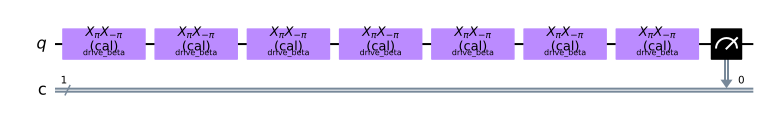

In [213]:
# n = 1

n = 1
XX = Gate("$X_\pi X_{-\pi}$", 1, [drive_beta])
qc_DRAG = QuantumCircuit(1, 1)
n = 2*k + 1
i = 0
while i < n:
    qc_DRAG.append(XX, [0])
    i += 1
qc_DRAG.measure(0, 0)
qc_DRAG.add_calibration(XX, (0,), XX_sched, [drive_beta])
exp_DRAG_circuits_n1 = [qc_DRAG.assign_parameters({drive_beta: b}, inplace=False) for b in drive_betas]
qc_DRAG.draw(output='mpl')

In [215]:
# n = 3

# for k in range(2):
n = 3
XX = Gate("$X_\pi X_{-\pi}$", 1, [drive_beta])
qc_DRAG = QuantumCircuit(1, 1)
i = 0
while i < n:
    qc_DRAG.append(XX, [0])
    i += 1
qc_DRAG.measure(0, 0)
qc_DRAG.add_calibration(XX, (0,), XX_sched, [drive_beta])
exp_DRAG_circuits_n3 = [qc_DRAG.assign_parameters({drive_beta: b}, inplace=False) for b in drive_betas]

In [216]:
# n = 5

n = 5
XX = Gate("$X_\pi X_{-\pi}$", 1, [drive_beta])
qc_DRAG = QuantumCircuit(1, 1)
i = 0
while i < n:
    qc_DRAG.append(XX, [0])
    i += 1
qc_DRAG.measure(0, 0)
qc_DRAG.add_calibration(XX, (0,), XX_sched, [drive_beta])
exp_DRAG_circuits_n5 = [qc_DRAG.assign_parameters({drive_beta: b}, inplace=False) for b in drive_betas]

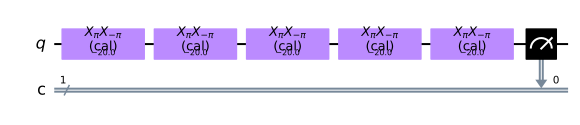

In [217]:
exp_DRAG_circuits_n5[0].draw(output='mpl')

In [218]:
# n = 7
n = 7
XX = Gate("$X_\pi X_{-\pi}$", 1, [drive_beta])
qc_DRAG = QuantumCircuit(1, 1)
i = 0
while i < n:
    qc_DRAG.append(XX, [0])
    i += 1
qc_DRAG.measure(0, 0)
qc_DRAG.add_calibration(XX, (0,), XX_sched, [drive_beta])
exp_DRAG_circuits_n7 = [qc_DRAG.assign_parameters({drive_beta: b}, inplace=False) for b in drive_betas]

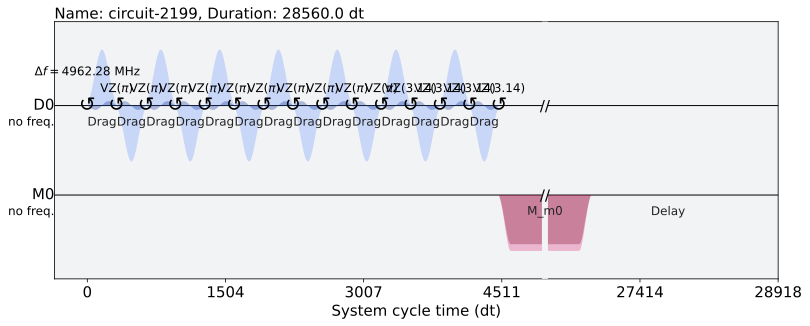

In [219]:
schedule(exp_DRAG_circuits_n7[7], backend).draw()

In [220]:
exp_DRAG_circuits = []
for i in exp_DRAG_circuits_n3:
    exp_DRAG_circuits.append(i)
for i in exp_DRAG_circuits_n5:
    exp_DRAG_circuits.append(i)
for i in exp_DRAG_circuits_n7:
    exp_DRAG_circuits.append(i)

In [221]:
drag_job = backend.run(exp_DRAG_circuits,
                       meas_level=MeasLevel.KERNELED,
                       meas_return=MeasReturnType.AVERAGE,
                       shots=2**14)

In [222]:
print(drag_job.job_id())

633edd21b4e213033f072251


In [223]:
job_monitor(drag_job)

Job Status: job has successfully run


In [83]:
# dragJob_n3 = backend.retrieve_job('633c44bb5765650b1c1165aa')
# dragJob_n5 = backend.retrieve_job('633c44bdbfe8f437459e2e78')
# dragJob_n7 = backend.retrieve_job('633c44bffeb64c4bf89ff98c')

In [44]:
def baselineRemover(values):
    return np.array(values) - np.mean(values)

num_beta_points = len(drive_betas)

In [224]:
drag_results = drag_job.result(timeout=120)
drag_values = []
for i in range(99):
    drag_values.append(drag_results.get_memory(i)[qubit] * 1e-7)
drag_values = np.real(baselineRemover(drag_values))

In [225]:
drag_values

array([ 1.75020426,  1.90047666,  1.95440206,  1.88399806,  1.73336386,
        1.44166426,  1.10052986,  0.73009466,  0.26566436, -0.21901075,
       -0.68465509, -1.12329824, -1.48981764, -1.76439404, -1.97896334,
       -2.08568394, -2.06279134, -1.96335094, -1.74991394, -1.44630534,
       -1.09181094, -0.63954569, -0.18258319,  0.30437188,  0.74287631,
        1.16149146,  1.47472836,  1.73807826,  1.89371666,  1.96250466,
        1.89876226,  1.75900126,  1.48513496, -1.98690054, -1.61600654,
       -0.99222104, -0.25603682,  0.49751816,  1.16361356,  1.69267846,
        1.94743606,  1.89352546,  1.51318916,  0.95044316,  0.24281266,
       -0.53591134, -1.24156894, -1.77829134, -2.04887554, -2.03511854,
       -1.71984184, -1.19242974, -0.50173482,  0.30930773,  1.01402256,
        1.58895626,  1.88048006,  1.92583626,  1.65245946,  1.16272756,
        0.47450596, -0.35368099, -1.07733084, -1.64584404, -2.01033474,
       -2.07699234,  0.92814736, -0.12018156, -1.14100064, -1.86

In [226]:
drag_values_n3 = drag_values[0:33]
drag_values_n5 = drag_values[33:66]
drag_values_n7 = drag_values[66:99]

In [227]:
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)

    return fitparams, y_fit

In [228]:
def sinusoid(x, fit_params):
    A, B, drive_period, phi = fit_params
    return A*np.cos(2*np.pi*x/drive_period - phi) + B

Best beta fit is -0.6606606606606604


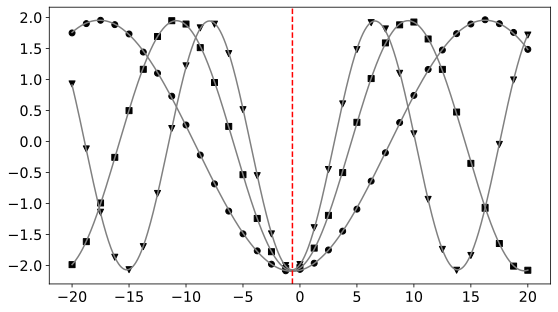

In [253]:
fit_params_n3, y_fit_n3 = fit_function(drive_betas,
                                       drag_values_n3,
                                       lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
                                       [2, 0, 40, 0])
fit_params_n5, y_fit_n5 = fit_function(drive_betas,
                                       drag_values_n5,
                                       lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
                                       [2, 0, 20, 0])
fit_params_n7, y_fit_n7 = fit_function(drive_betas,
                                       drag_values_n7,
                                       lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
                                       [2, 0, 20, 0])
x_val = np.linspace(-20, 20, 1000)
plt.scatter(drive_betas, drag_values_n3, marker='o', linestyle='-', color='black')
plt.plot(x_val, sinusoid(x_val, fit_params_n3), color = 'gray')
plt.scatter(drive_betas, drag_values_n5, marker='s', linestyle='-', color='black')
plt.plot(x_val, sinusoid(x_val, fit_params_n5), color = 'gray')
plt.scatter(drive_betas, drag_values_n7, marker='v', linestyle='-', color='black')
plt.plot(x_val, sinusoid(x_val, fit_params_n7), color = 'gray')
# plt.axvline(x_optimum, linestyle='-', color='red')
# plt.axvline(x_optimum+0.8, linestyle='--', color='red')
plt.axvline(x_optimum, linestyle='--', color='red')
print(f'Best beta fit is {x_optimum}')

In [246]:
min_val = 1
beta_optimum = 0
for x in x_val:
    l = (sinusoid(x, fit_params_n3) + np.abs(fit_params_n3[0]) - fit_params_n3[1])**2 + (sinusoid(x, fit_params_n5) + np.abs(fit_params_n5[0]) - fit_params_n5[1])**2 + (sinusoid(x, fit_params_n7) + np.abs(fit_params_n7[0]) - fit_params_n7[1])**2
    if l < min_val:
        min_val = l
        x_optimum = x